In [1]:
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')








In [2]:
data_dir = r"D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB_Chest_Radiography_Database\image7500f"
filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        filepaths.append(file_path)
        label = os.path.basename(root)
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print(df)

                                              filepaths        labels
0     D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...        Normal
1     D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...        Normal
2     D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...        Normal
3     D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...        Normal
4     D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...        Normal
...                                                 ...           ...
6995  D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...  Tuberculosis
6996  D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...  Tuberculosis
6997  D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...  Tuberculosis
6998  D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...  Tuberculosis
6999  D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...  Tuberculosis

[7000 rows x 2 columns]


In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=123)

In [4]:
batch_size = 32
img_size = (224, 224)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

g_dict = train_gen.class_indices
classes = list(g_dict.keys())
class_count = len(classes)


Found 5600 validated image filenames belonging to 2 classes.
Found 1400 validated image filenames belonging to 2 classes.


In [5]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(train_gen.class_indices)

base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

base_model.trainable = False  

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512, kernel_initializer='he_normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_regularizer=regularizers.l2(0.009), activity_regularizer=regularizers.l1(0.019),
          bias_regularizer=regularizers.l1(0.019), activation='relu'),
    Dropout(0.20),
    Dense(128, kernel_initializer='he_uniform', activation='relu'),
    Dropout(0.1),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [6]:
epochs = 10

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/10
175/175 [==============================] - 3637s 21s/step - loss: 2.0400 - accuracy: 0.9302 - val_loss: 0.7126 - val_accuracy: 0.9643 - lr: 0.0010
Epoch 2/10
175/175 [==============================] - 2942s 17s/step - loss: 0.4386 - accuracy: 0.9620 - val_loss: 0.2439 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 3/10
175/175 [==============================] - 1944s 11s/step - loss: 0.2345 - accuracy: 0.9689 - val_loss: 0.1737 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 4/10
175/175 [==============================] - 2892s 17s/step - loss: 0.1860 - accuracy: 0.9716 - val_loss: 0.1721 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 5/10
175/175 [==============================] - 29386s 169s/step - loss: 0.1729 - accuracy: 0.9748 - val_loss: 0.1615 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 6/10
175/175 [==============================] - 1981s 11s/step - loss: 0.1692 - accuracy: 0.9748 - val_loss: 0.1319 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 7/10
175/175 [==============================

In [7]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(test_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


20/20 [==============================] - 185s 9s/step - loss: 0.1269 - accuracy: 0.9844
Train Loss:  0.10602442920207977
Train Accuracy:  0.989062488079071
--------------------
Validation Loss:  0.12687385082244873
Validation Accuracy:  0.984375
--------------------
Test Loss:  0.12687385082244873
Test Accuracy:  0.984375


In [8]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)




44/44 [==============================] - 401s 9s/step


In [9]:
from sklearn.metrics import classification_report

classes = list(train_gen.class_indices.keys())
print(classification_report(test_gen.classes, y_pred, target_names=classes))
                           

              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       700
Tuberculosis       0.99      0.97      0.98       700

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.98      0.98      0.98      1400



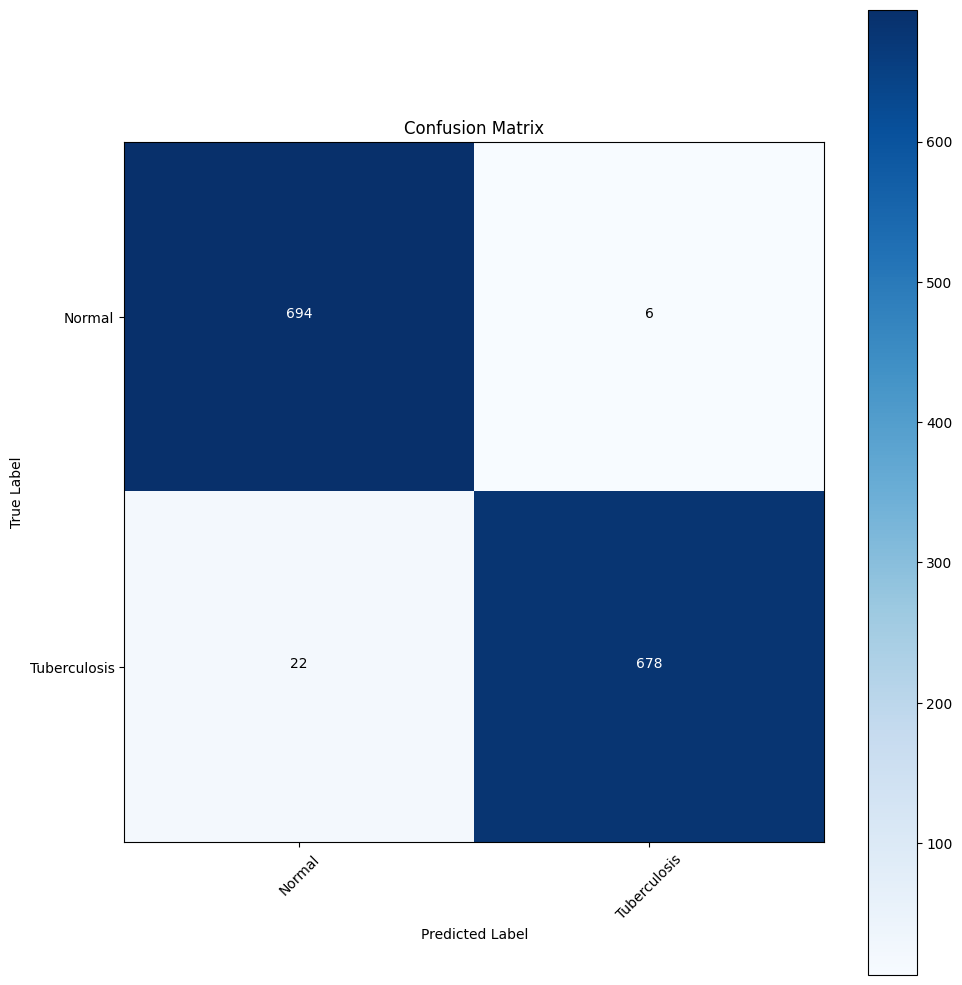

In [10]:
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

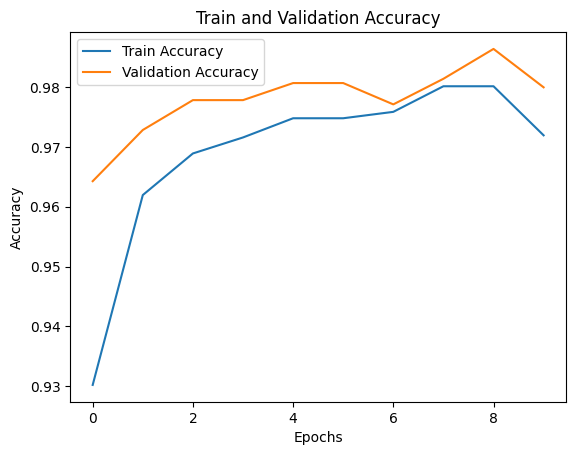

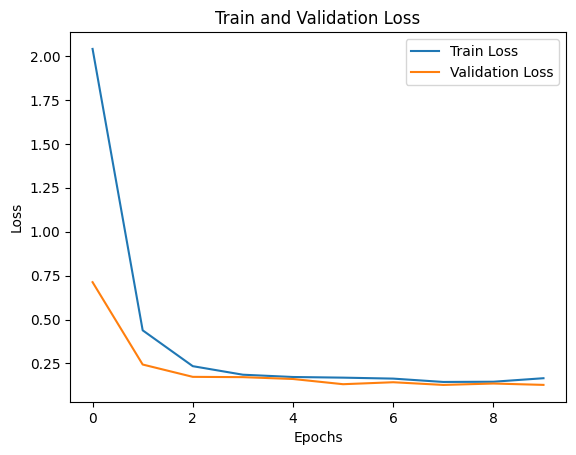

In [11]:
# Plotting train and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting train and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
import tensorflow as tf
import pickle

# Save the model in HDF5 format
model.save(r"D:\CAPSTONE 400A\model\vgg19cus.h5")



In [13]:
model.save("vgg19cus.h5")